# Imports

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV

## some data constants

In [2]:
subjects = 40
photos = 10
samples = subjects * photos
width = 92
length = 112
pixels = 10304

# Load Data

In [3]:
# inisialize a zeros vector to stack features on and an empty labels vector
features = np.zeros((1, pixels))
labels = []

for i in range(1, subjects+1):
    for j in range(1, photos+1):
        img = Image.open(f"data/s{i}/{j}.pgm")
        img = np.asarray(img)
        img = img.reshape(1,-1)
        
        features = np.vstack((features, img))
        labels.append(i)

# drop the initial zeros row
features = features[1:]
labels = np.array(labels)


In [4]:
features.shape

(400, 10304)

In [5]:
labels.shape

(400,)

# View A Few Samples

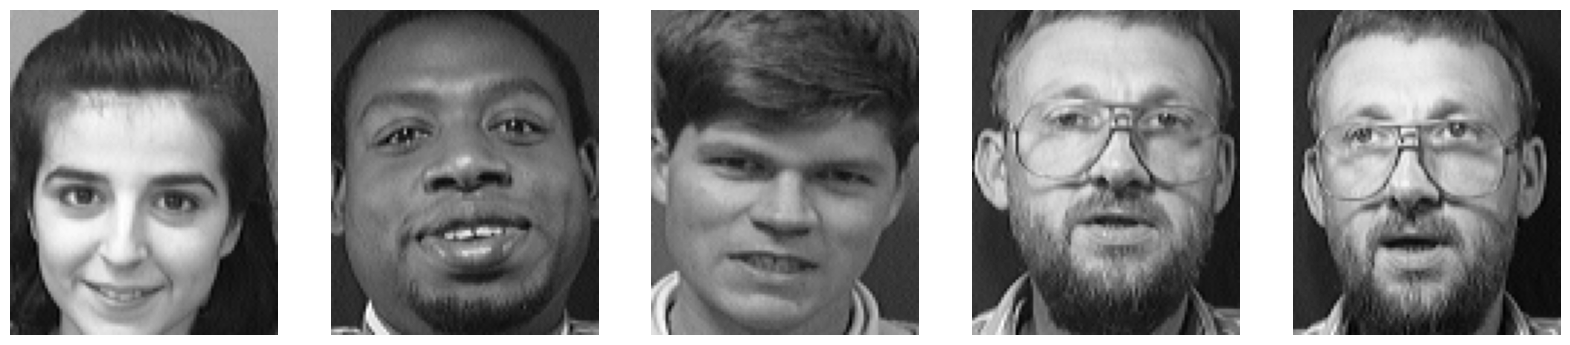

In [6]:
fig, ax = plt.subplots(1, 5, figsize = (20,30))

for i in range(5):
    ax[i].imshow(features[np.random.randint(0, 400),:].reshape(length, width), cmap="gray")
    ax[i].axis("off")

# Split The Data

In [7]:
x_train, x_eval, y_train, y_eval = train_test_split(features, labels, test_size=0.5,
                                                     random_state=0, stratify=labels,)

In [8]:
pd.value_counts(y_train)

13    5
34    5
1     5
20    5
32    5
8     5
19    5
28    5
31    5
5     5
38    5
23    5
24    5
37    5
35    5
33    5
7     5
2     5
6     5
26    5
10    5
39    5
30    5
36    5
40    5
29    5
18    5
27    5
4     5
16    5
21    5
25    5
11    5
3     5
17    5
9     5
22    5
15    5
14    5
12    5
Name: count, dtype: int64

# PCA 

In [9]:
# calculate the mean
mean = np.mean(features, axis=0)
mean.shape

(10304,)

In [10]:
# center the data
x_meaned = features - mean
x_meaned.shape

(400, 10304)

In [11]:
# calculate covariance matrix
covariance = np.cov(x_meaned, rowvar=False)
covariance.shape

(10304, 10304)

In [12]:
eig_values, eig_vectors = np.linalg.eigh(covariance)    # calculate eigen values and vectors
eig_values = np.flip(eig_values)                        # flip values to get the descending order
eig_vectors = np.flip(eig_vectors, axis=1)              # flip vectors to get the descending order

In [18]:
# define the alphas we will test
alphas = [0.8, 0.85, 0.9, 0.95]

# calculate sum of eigen values for later calculations
eigen_sum = eig_values.sum()

In [23]:
# calculate the least dimensions that satisfy every alpha
dimensions = []
for alpha in alphas:
    acc = eig_values[0]
    i = 1

    while acc / eigen_sum < alpha:
        acc += eig_values[i]
        i += 1
        
    dimensions.append(i) 


In [30]:
dimensions

[44, 68, 111, 190]

In [25]:
# get the basis for every alpha
basis = [np.array(eig_vectors[:,0:dimension]) for dimension in dimensions]
# basis = [base.T for base in basis]
[base.shape for base in basis]

[(10304, 44), (10304, 68), (10304, 111), (10304, 190)]

In [28]:
# get the projections on every basis

projections = [x_meaned @ base for base in basis]

In [29]:
[projection.shape for projection in projections]

[(400, 44), (400, 68), (400, 111), (400, 190)]

In [33]:
reconstructions = np.array([proj @ base.T + mean for proj,base in zip(projections, basis)])

In [34]:
reconstructions.shape

(4, 400, 10304)

# Visialize The Eigen Faces 

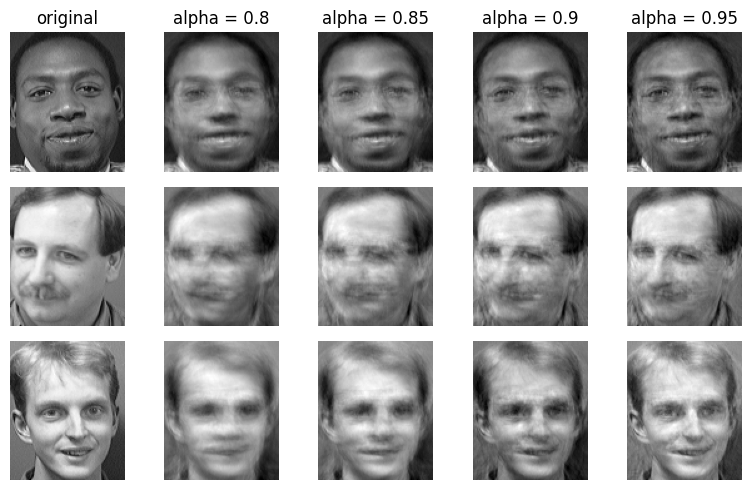

In [52]:
fig, ax = plt.subplots(3, 5, figsize = (8,5))

ax[0][0].set_title(f"original")
for i in range(1,5):
    ax[0][i].set_title(f"alpha = {alphas[i-1]}")

for i in range(3):
    ind = np.random.randint(0, 400)
    ax[i][0].imshow(features[ind,:].reshape(length, width), cmap="gray")
    ax[i][0].axis("off")

    for j in range(1, 5):
        img = reconstructions[j-1][ind]

        ax[i][j].imshow(img.reshape(length, width), cmap="gray")
        ax[i][j].axis("off")
fig.tight_layout()

# Train the model

In [53]:
model = KNN()

params = {
    "n_neighbors": list(range(3,10,2))
}

model_cv = GridSearchCV(model, param_grid=params, cv=10,
                       return_train_score=True, scoring="accuracy")

In [55]:
for i, proj in enumerate(projections):
    model_cv.fit(proj, labels)
    results = pd.DataFrame(model_cv.cv_results_)
    knn_selected_results = results[["param_n_neighbors", "mean_test_score", "mean_train_score"]]
    print(f"alpha: {alphas[i]}\n", knn_selected_results, "\n\n")


alpha: 0.8
   param_n_neighbors  mean_test_score  mean_train_score
0                 3           0.9600          0.987500
1                 5           0.9300          0.968889
2                 7           0.9000          0.940833
3                 9           0.8575          0.906389 


alpha: 0.85
   param_n_neighbors  mean_test_score  mean_train_score
0                 3           0.9700          0.985833
1                 5           0.9300          0.973056
2                 7           0.9150          0.944444
3                 9           0.8575          0.909444 


alpha: 0.9
   param_n_neighbors  mean_test_score  mean_train_score
0                 3           0.9625          0.985000
1                 5           0.9300          0.971667
2                 7           0.9000          0.933889
3                 9           0.8575          0.898056 


alpha: 0.95
   param_n_neighbors  mean_test_score  mean_train_score
0                 3           0.9575          0.982500
1     